## <div  style="color:black;  font-size:100%; text-align:left;padding:12.0px; background:#ffffff"> Welcome to the Abstraction and Reasoning Challenge (ARC), a potential major step towards achieving artificial general intelligence (AGI)! In this competition, we are challenged to build an algorithm that can perform reasoning tasks it has never seen before. Classic machine learning problems generally involve one specific task which can be solved by training on millions of data samples. But in this challenge, we need to build an algorithm that can learn patterns from a minimal number of examples. </div>

## <div  style="color:#D35142;  font-weight:bold; font-size:100%; text-align:center;padding:12.0px; background:#ffffff"> Please upvote this kernel if you like it. It motivates me to produce more quality content) </div>





<center>
<img src="https://i.postimg.cc/26RtyM0s/3221asdf.jpg" width=1100>
</center>



# <div  style="color:white; border:lightgreen solid;  font-weight:bold; font-size:120%; text-align:center;padding:12.0px; background:black">1. OVERVIEW</div>


# Goal
The objective of this competition is to create an algorithm that is capable of solving abstract reasoning tasks. Critically, these are novel tasks: tasks that the algorithm has never seen before. Hence, **simply memorizing** a set of reasoning templates will **not suffice**.

The goal is to construct the output grid(s) corresponding to the test input grid(s), using 2 trials for each test input.

# Task overview

We can classify several typical transformations:

**PROBLEMS**

- **Geometry**
    - do nothing
    - rotate / mirror / shift image
    - crop image background
    - draw border


- **Objects**
    - rotate / mirror / shirt objects
    - move two objects together
    - move objects to edge
    - extend / repeat an object
    - delete an object
    - count unique objects and select the object that appears the most times
    - create pattern based on image colors
    - overlay object
    - replace objects


- **Coloring**
    - select colors for objects
    - select dominant/smallest color in image
    - denoise
    - fill in empty spaces


- **Lines**
    - color edges
    - extrapolate a straight/diagonal line
    - draw a line between two dots / or inersections between such lines
    - draw a spiral


- **Grids**
    - select grid squares with most pixels


- **Patterns**
    - complete a symmetrical/repeating pattern 


- **Subtasks**
    - object detection / cohesion / seperation
    - object persistance
    - counting or sorting objects


If such problem classes can be correctly detected, it may be possible to get some quick wins by writing a libary of simple solvers for known problems. These could be tried in sequence before resorting to more advanced general purpose algorithms.

# Data overview

 

"Constructing the output grid" involves picking the height and width of the output grid, then filling each cell in the grid with a symbol (integer between 0 and 9, which are visualized as **colors**). **Only exact solutions** (all cells match the expected answer) can be said to be correct.

# <div  style="color:white; border:lightgreen solid;  font-weight:bold; font-size:120%; text-align:center;padding:12.0px; background:black">2. DATA LOADING AND PREPARATION</div>


## Import libraries and define parameters

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from   matplotlib import colors
import seaborn as sns

import json
import os
from pathlib import Path

from subprocess import Popen, PIPE, STDOUT
from glob import glob

In [2]:
base_path='/kaggle/input/arc-prize-2024/'
# Loading JSON data
def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

In [3]:
# Reading files
training_challenges =  load_json(base_path +'arc-agi_training_challenges.json')
training_solutions =   load_json(base_path +'arc-agi_training_solutions.json')
evaluation_challenges =load_json(base_path +'arc-agi_evaluation_challenges.json')
evaluation_solutions = load_json(base_path +'arc-agi_evaluation_solutions.json')


# <div  style="color:white; border:lightgreen solid;  font-weight:bold; font-size:120%; text-align:center;padding:12.0px; background:black">3. DATA EXPLORATION</div>


All datasets have 400 JSON tasks:

In [4]:
print(f'Number of training challenges = {len(training_challenges)}')

Number of training challenges = 400


In [5]:
print(f'Number of training solutions = {len(training_solutions)}')

Number of training solutions = 400


In [6]:
print(f'Number of evaluation challenges = {len(evaluation_challenges)}')

Number of evaluation challenges = 400


In [7]:
print(f'Number of evaluation solutions = {len(evaluation_solutions)}')

Number of evaluation solutions = 400


The names of the first fife ""training challenges" are shown below:

In [8]:
for i in range(5):
    t=list(training_challenges)[i]
    task=training_challenges[t]
    print(f'Set #{i}, {t}')

Set #0, 007bbfb7
Set #1, 00d62c1b
Set #2, 017c7c7b
Set #3, 025d127b
Set #4, 045e512c


In each task, there are **two** dictionary keys, **train** and **test**. We learn the pattern from the train input-output pairs, and then apply the pattern to the test input, to predict an output.

In [9]:
task = training_challenges['007bbfb7']
print(task.keys())

dict_keys(['test', 'train'])


Tasks have multiple train input-output pairs. Most tasks have a single test input-output pair, although some have more than one.

In [10]:
n_train_pairs = len(task['train'])
n_test_pairs = len(task['test'])

print(f'task contains {n_train_pairs} training pairs')
print(f'task contains {n_test_pairs} test pairs')

task contains 5 training pairs
task contains 1 test pairs


Dive into the first train input-output pair, we can see the grids are expressed as 2d lists with integers 0-9:

In [11]:
display(task['train'][0]['input'])
display(task['train'][0]['output'])

[[0, 7, 7], [7, 7, 7], [0, 7, 7]]

[[0, 0, 0, 0, 7, 7, 0, 7, 7],
 [0, 0, 0, 7, 7, 7, 7, 7, 7],
 [0, 0, 0, 0, 7, 7, 0, 7, 7],
 [0, 7, 7, 0, 7, 7, 0, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7],
 [0, 7, 7, 0, 7, 7, 0, 7, 7],
 [0, 0, 0, 0, 7, 7, 0, 7, 7],
 [0, 0, 0, 7, 7, 7, 7, 7, 7],
 [0, 0, 0, 0, 7, 7, 0, 7, 7]]

### Function to plot input/output pairs of a task

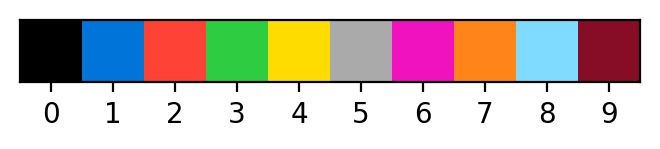

In [12]:
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow, # 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown

_cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

plt.figure(figsize=(4, 1), dpi=200)
plt.imshow([list(range(10))], cmap=_cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

In [13]:
def plot_one(ax, i,train_or_test,input_or_output):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)

    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+input_or_output)
    

def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(axs[0,i],i,'train','input')
        plot_one(axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
#     num_test = len(task['test'])
#     fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
#     if num_test==1: 
#         plot_one(axs[0],0,'test','input')
#         plot_one(axs[1],0,'test','output')     
#     else:
#         for i in range(num_test):      
#             plot_one(axs[0,i],i,'test','input')
#             plot_one(axs[1,i],i,'test','output')  
#     plt.tight_layout()
#     plt.show() 

# Visualization Training set

Set #0, 007bbfb7


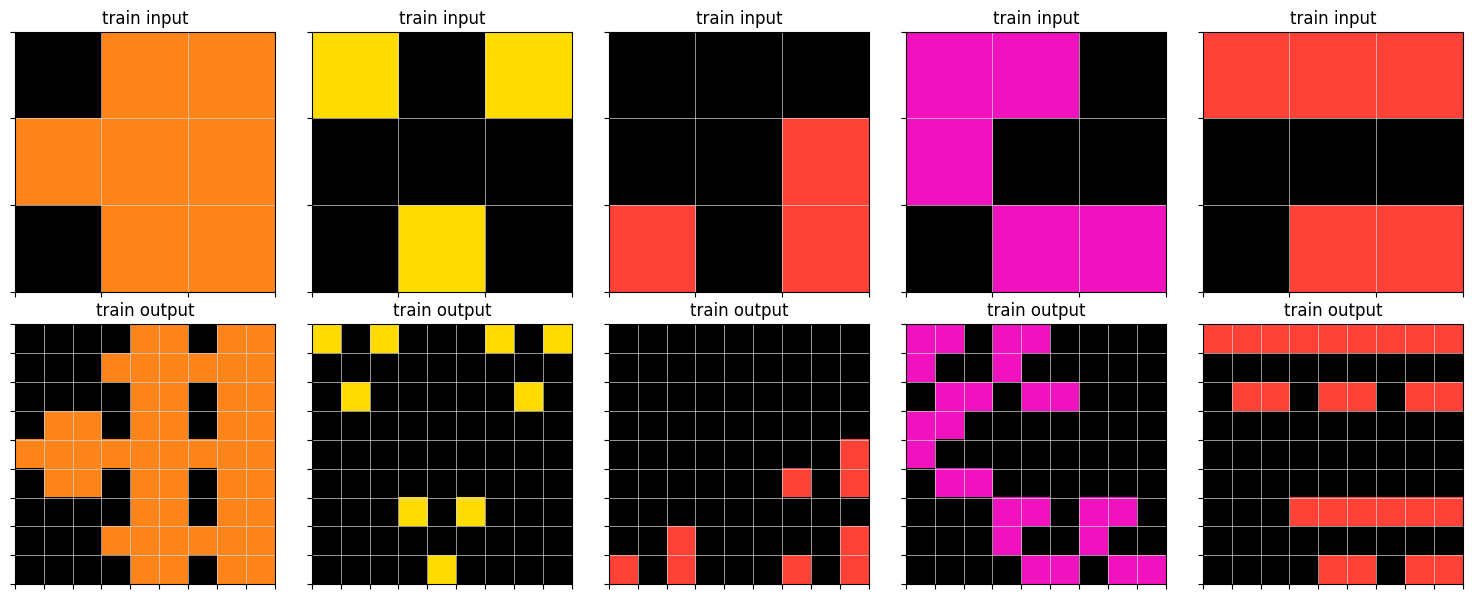

Set #1, 00d62c1b


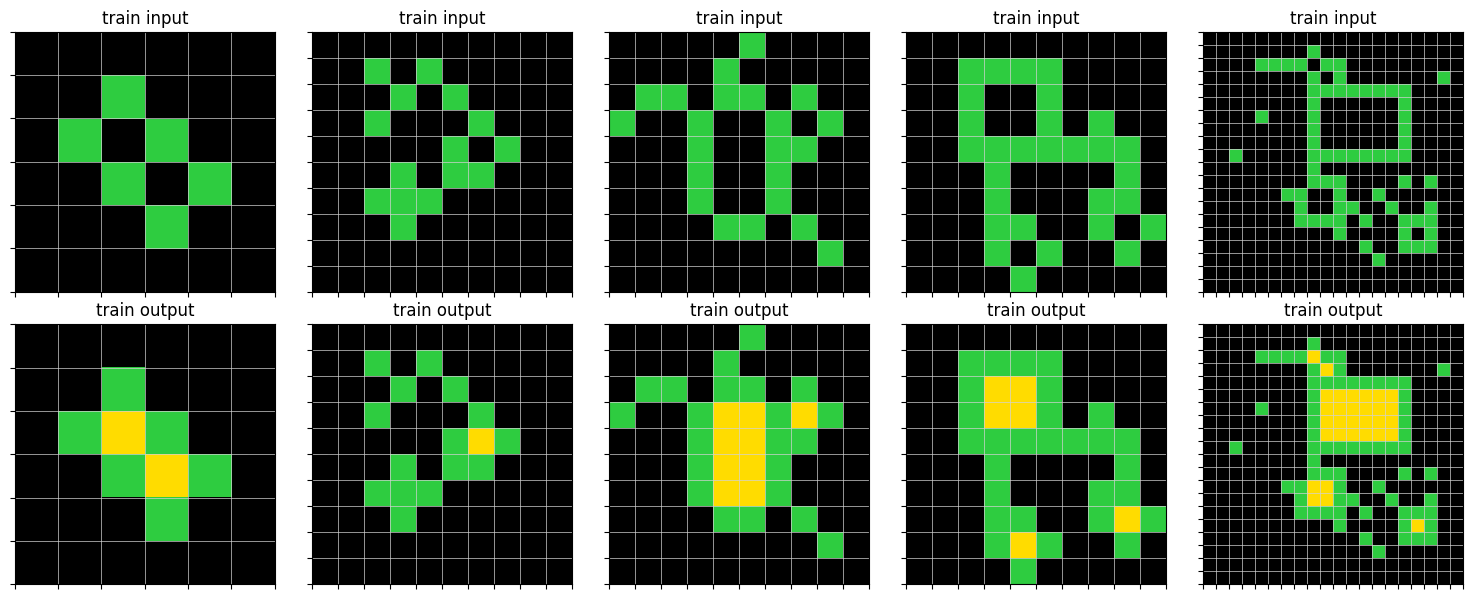

Set #2, 017c7c7b


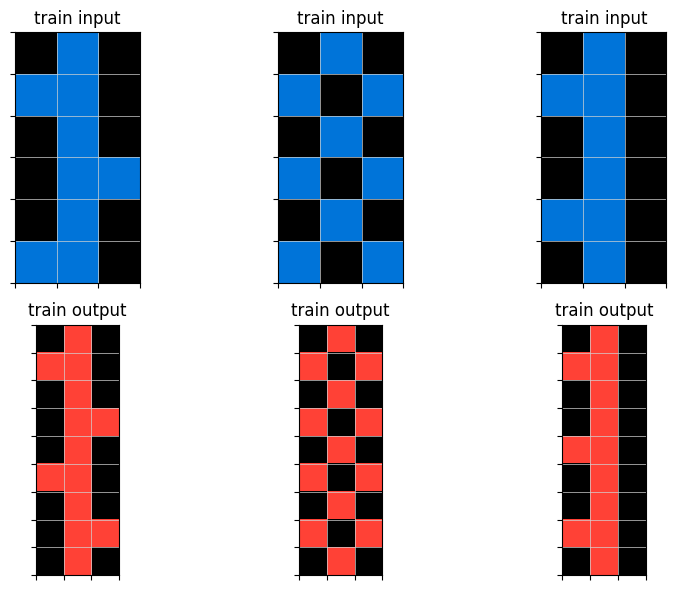

Set #3, 025d127b


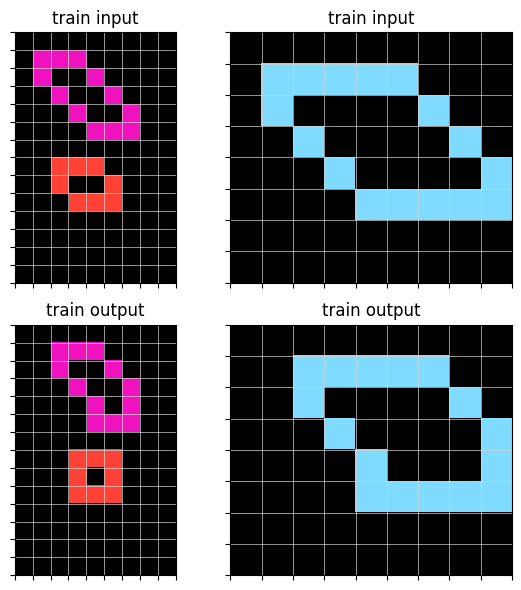

Set #4, 045e512c


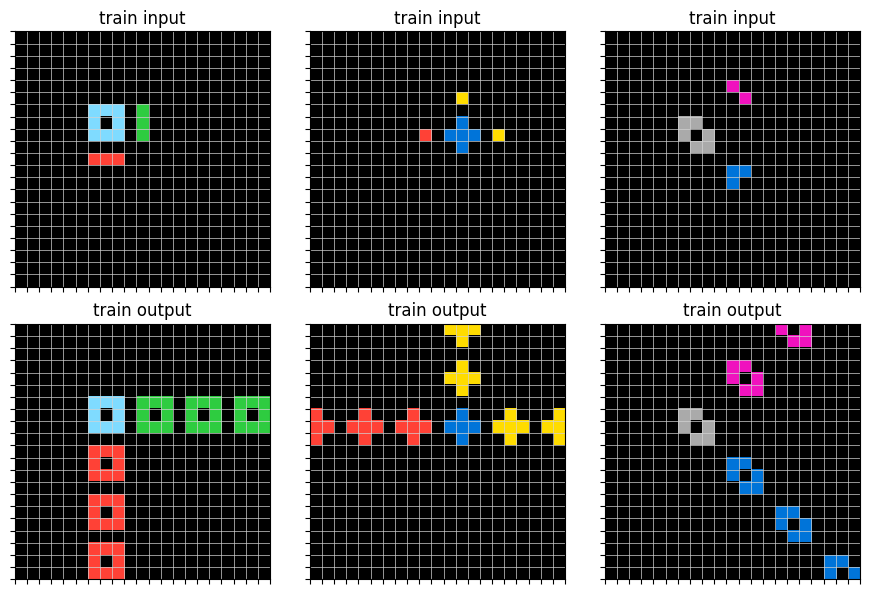

Set #5, 0520fde7


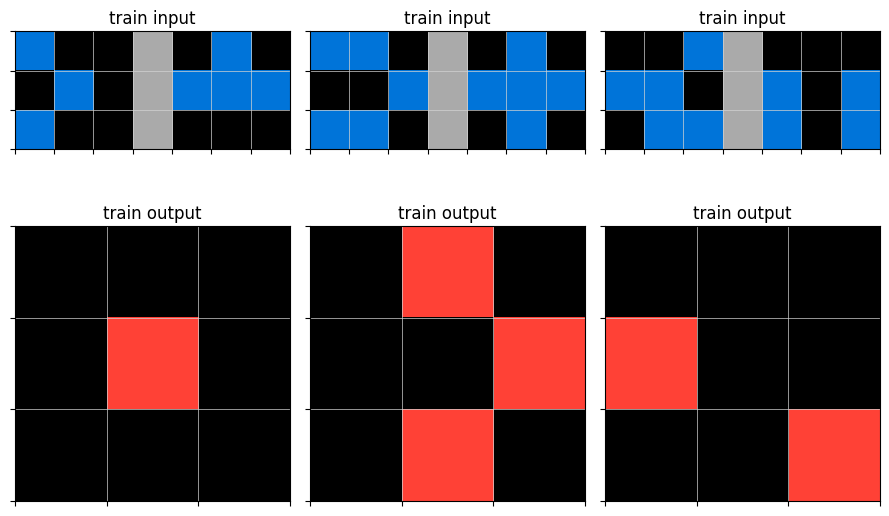

Set #6, 05269061


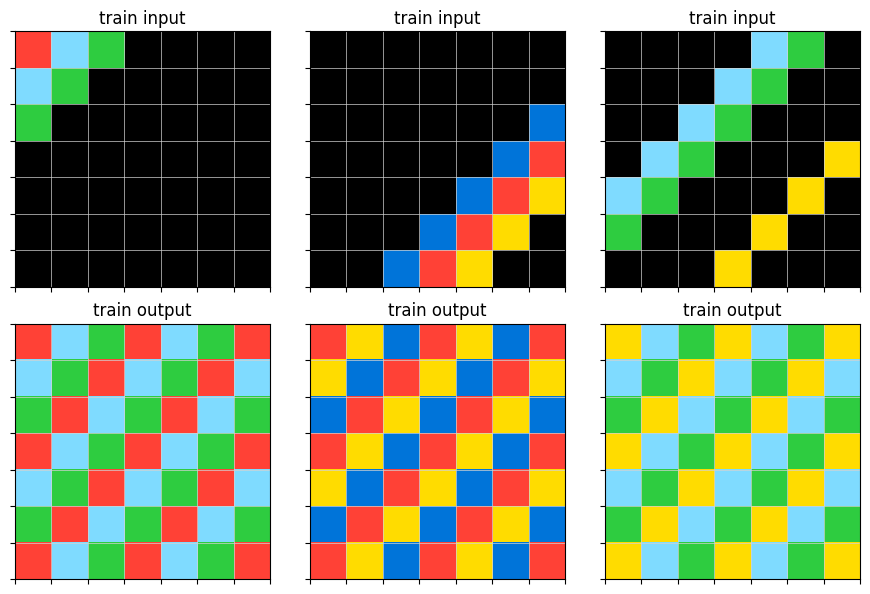

Set #7, 05f2a901


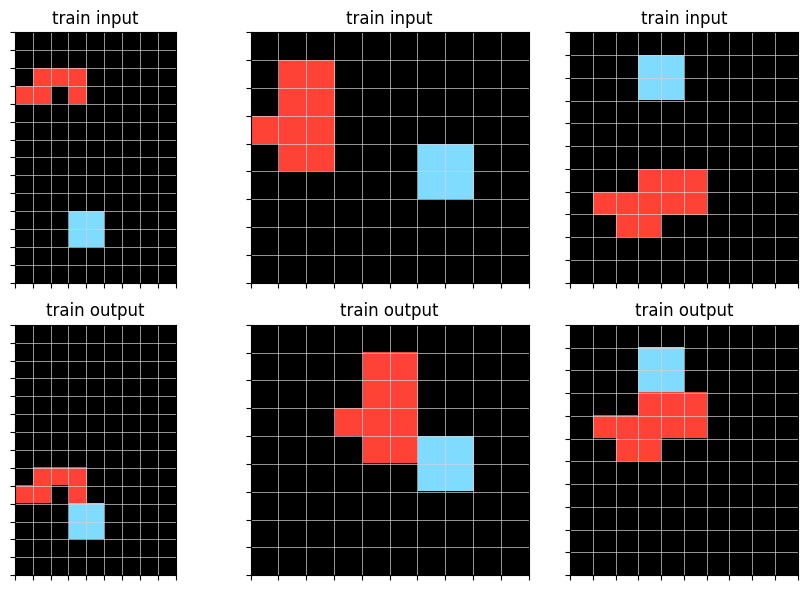

Set #8, 06df4c85


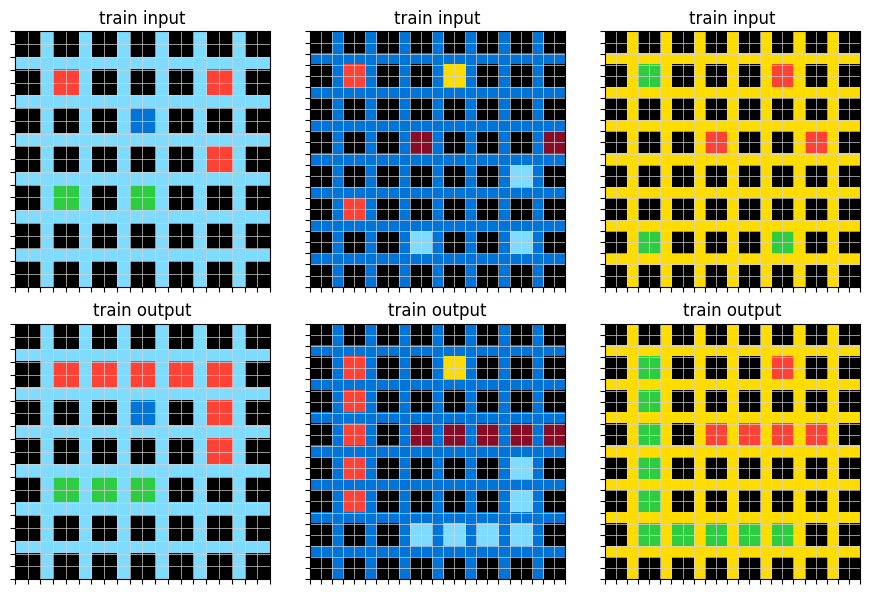

Set #9, 08ed6ac7


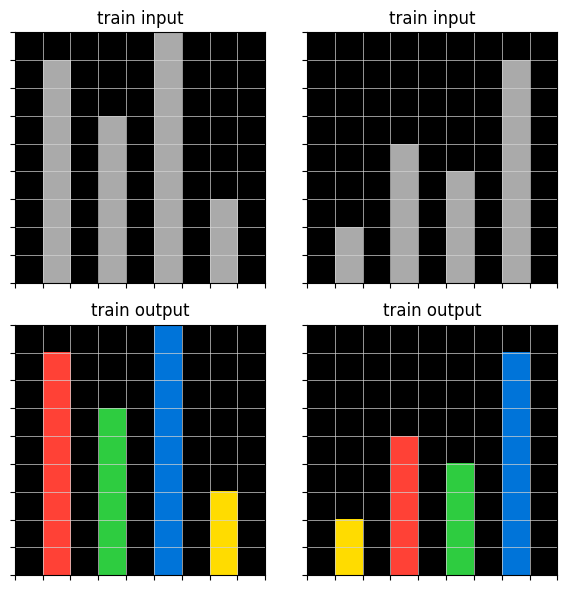

Set #10, 09629e4f


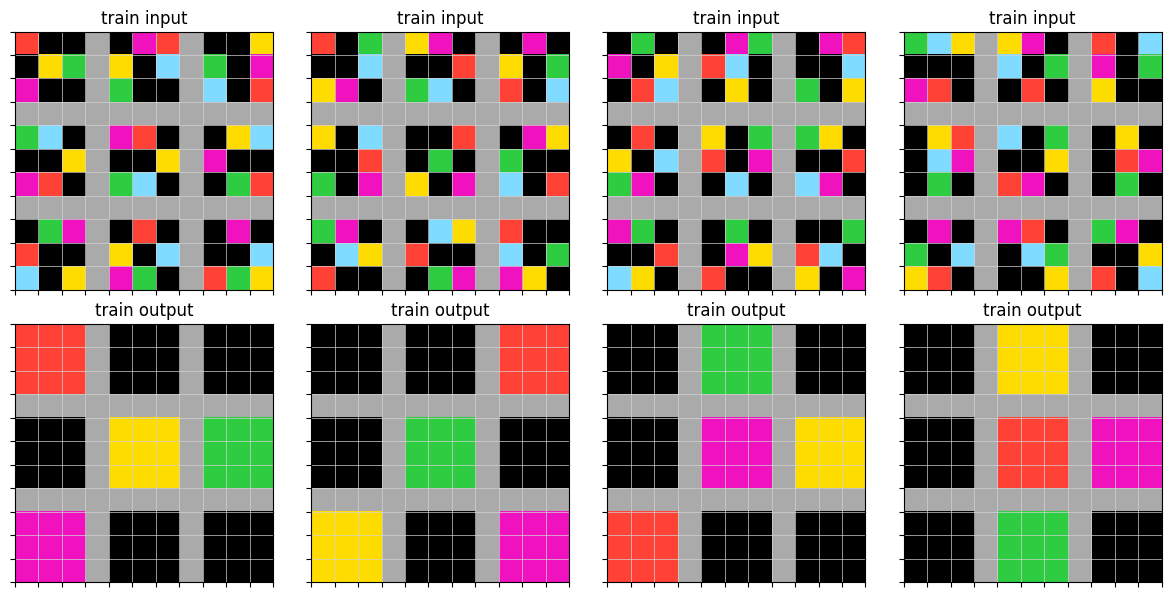

Set #11, 0962bcdd


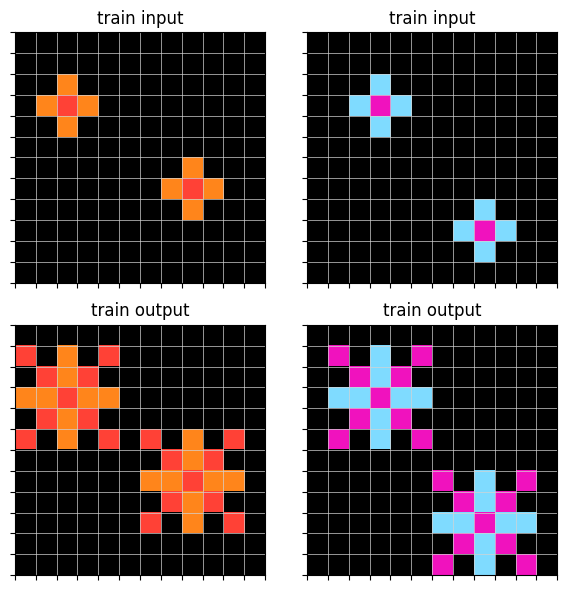

Set #12, 0a938d79


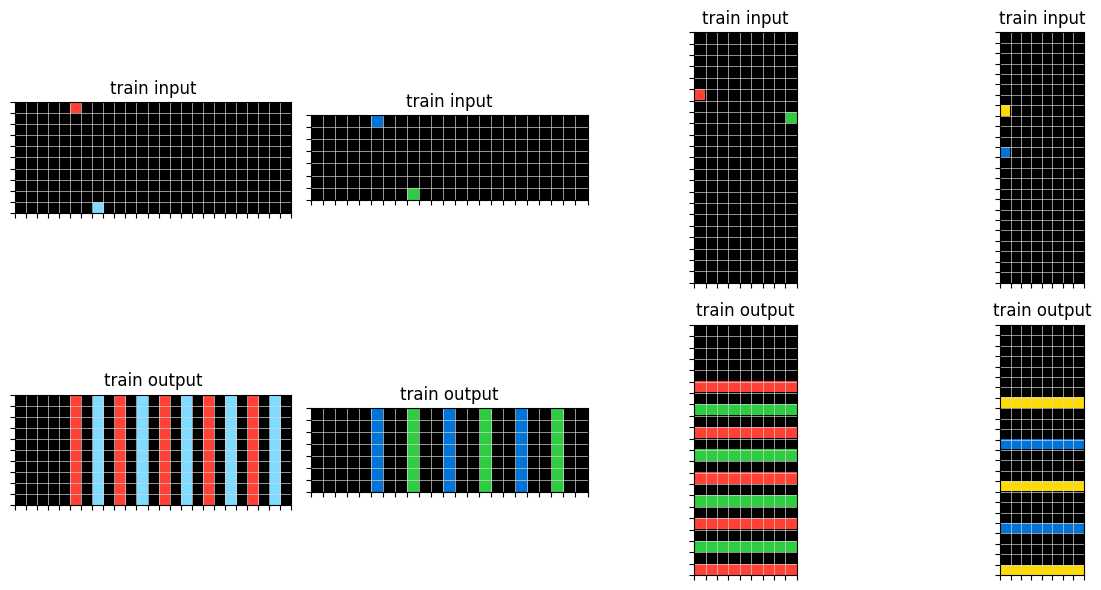

Set #13, 0b148d64


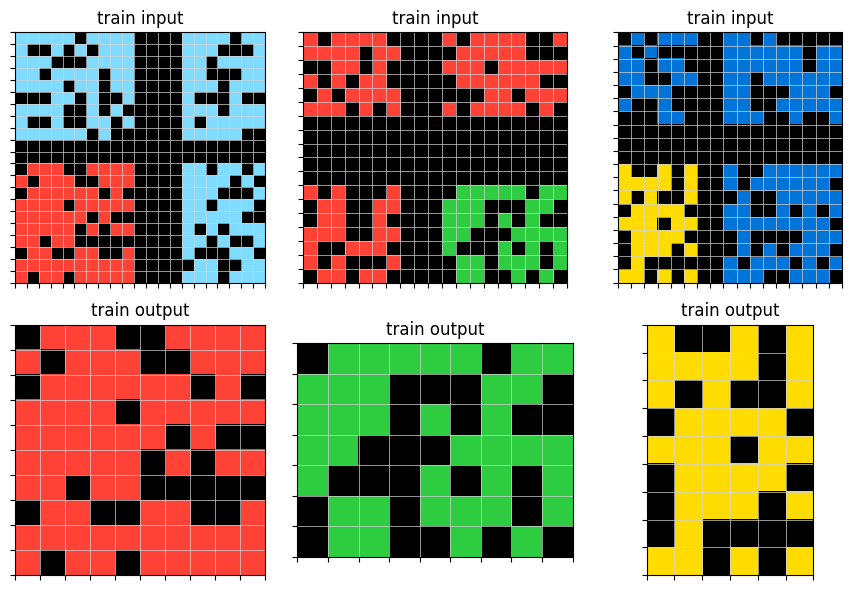

Set #14, 0ca9ddb6


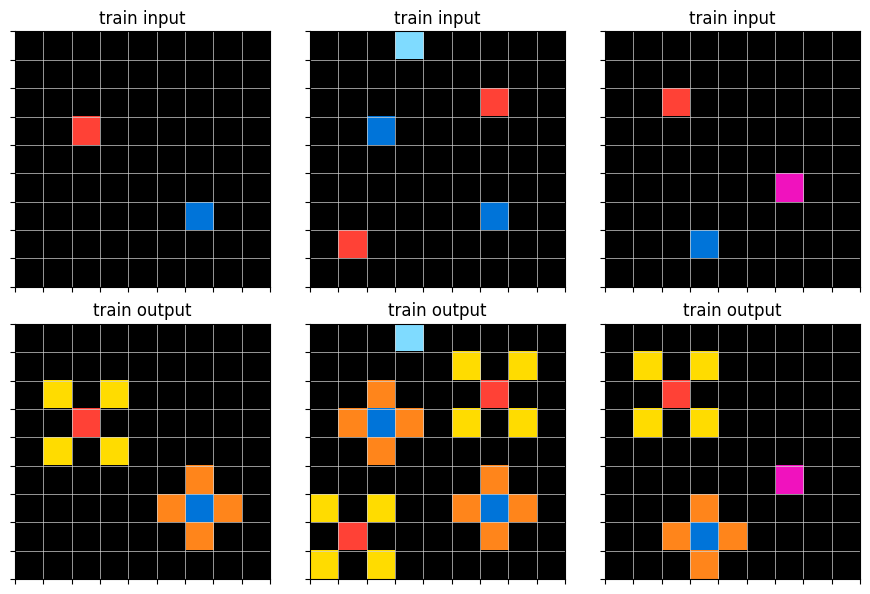

Set #15, 0d3d703e


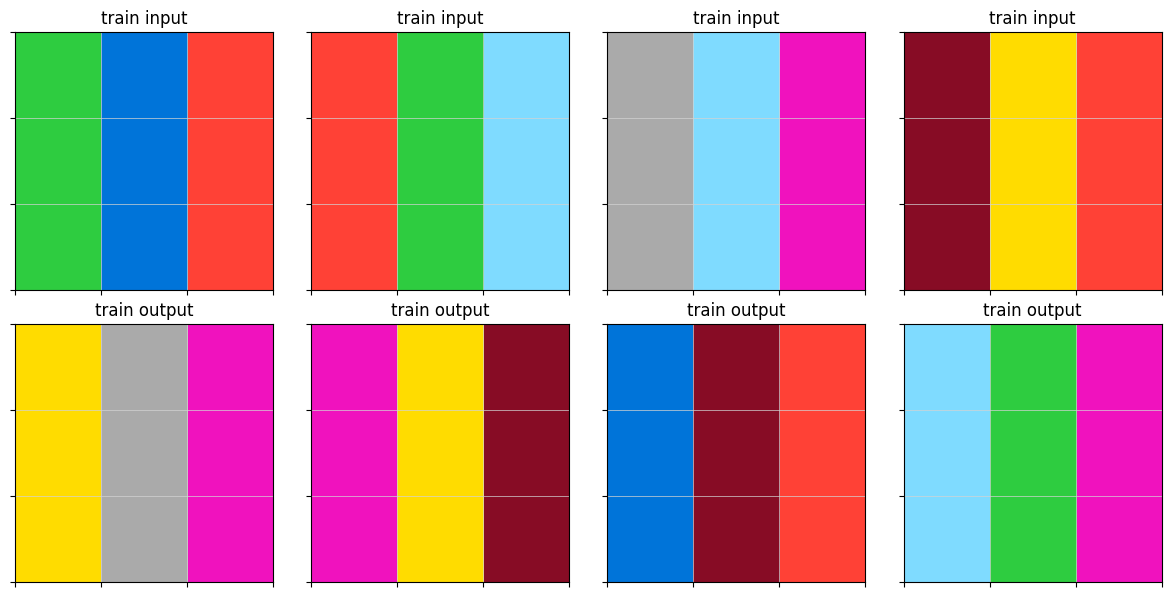

Set #16, 0dfd9992


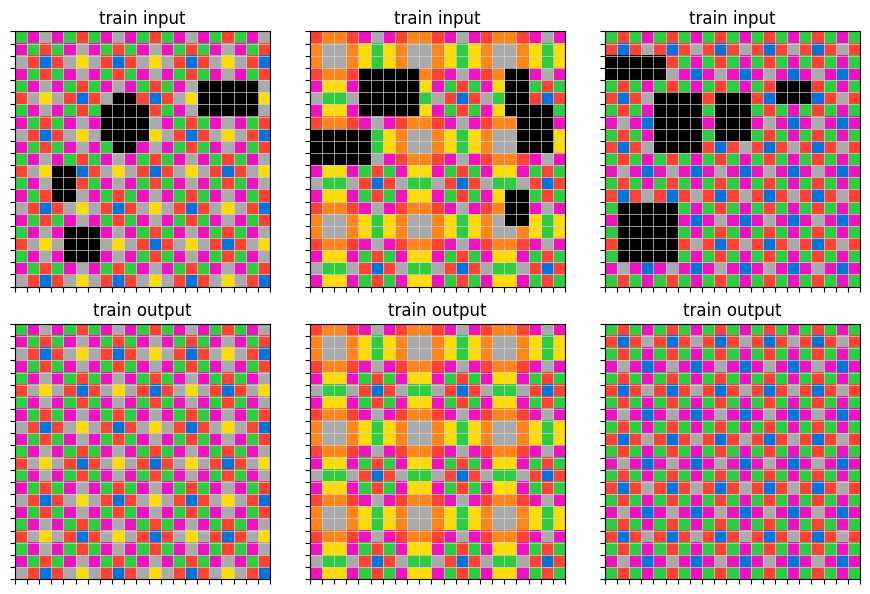

Set #17, 0e206a2e


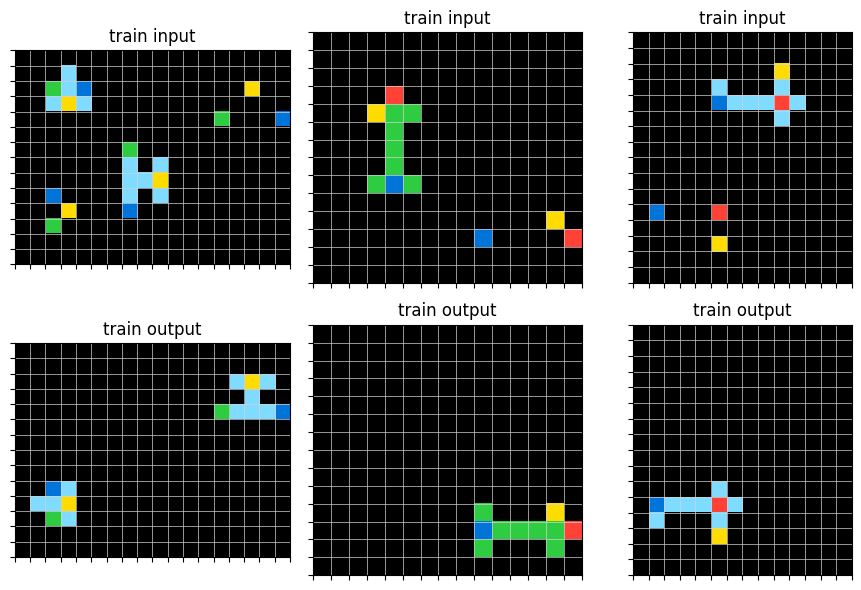

Set #18, 10fcaaa3


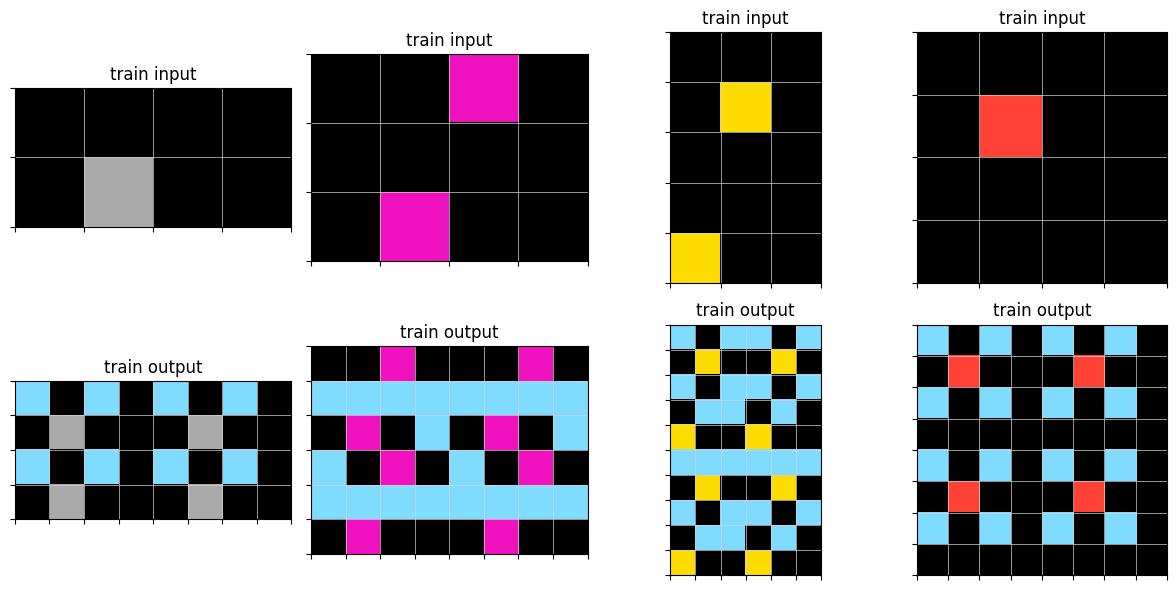

Set #19, 11852cab


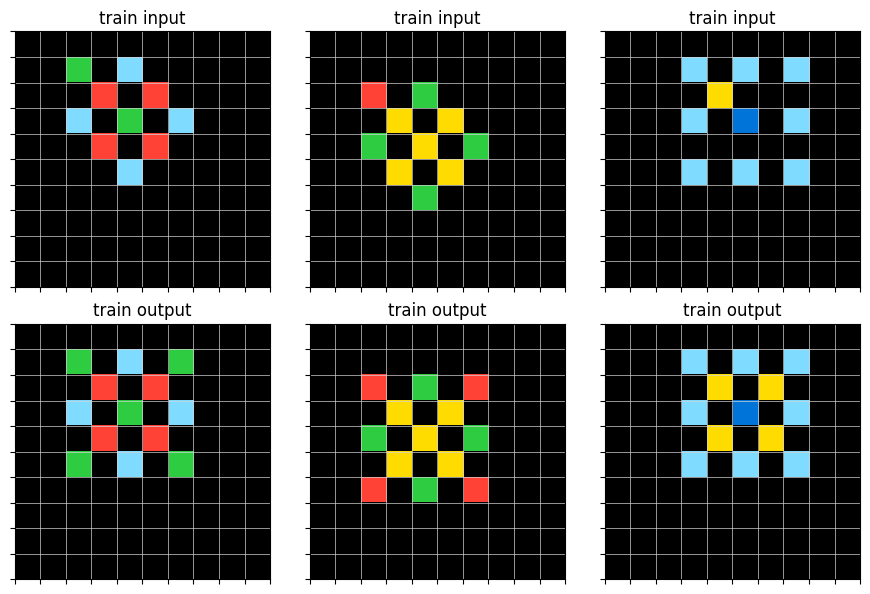

In [14]:
for i in range(20):
    t=list(training_challenges)[i]
    task=training_challenges[t]
    print(f'Set #{i}, {t}')
    plot_task(task)

# Visualization Evaluating set

Set #0, 00576224


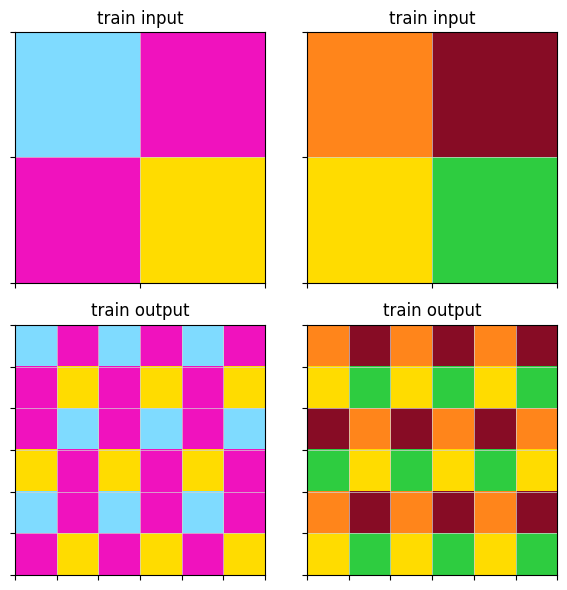

Set #1, 009d5c81


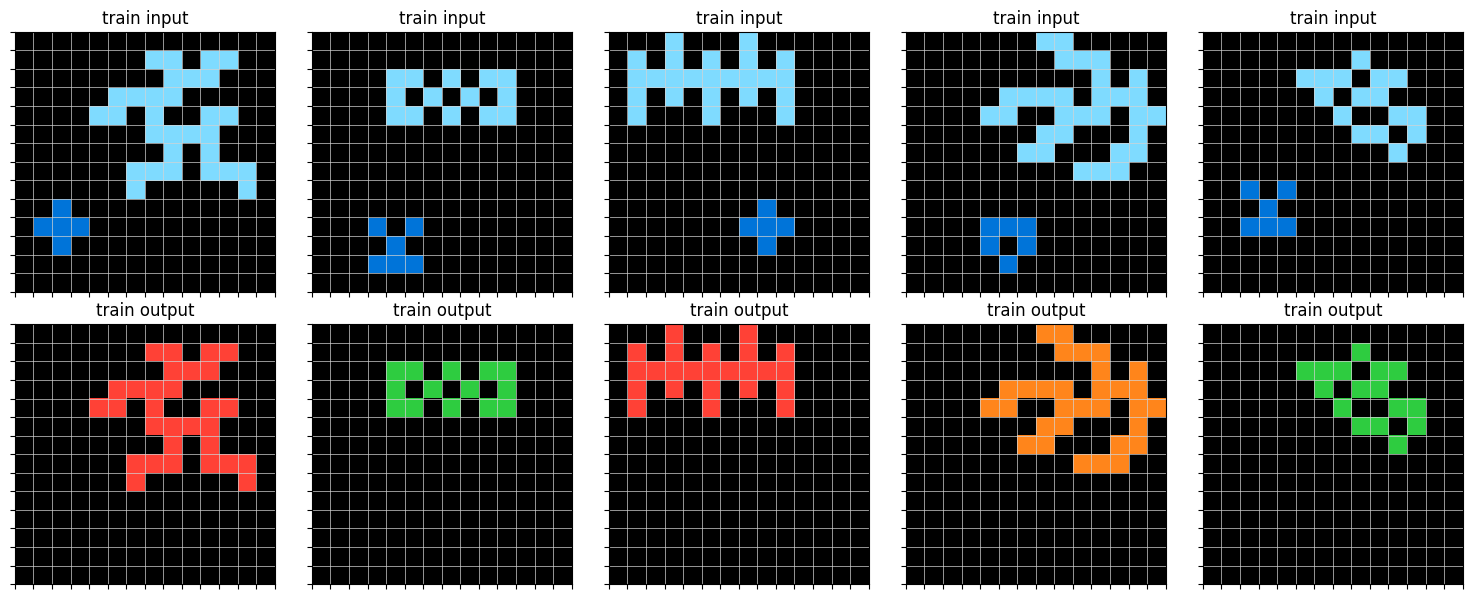

Set #2, 00dbd492


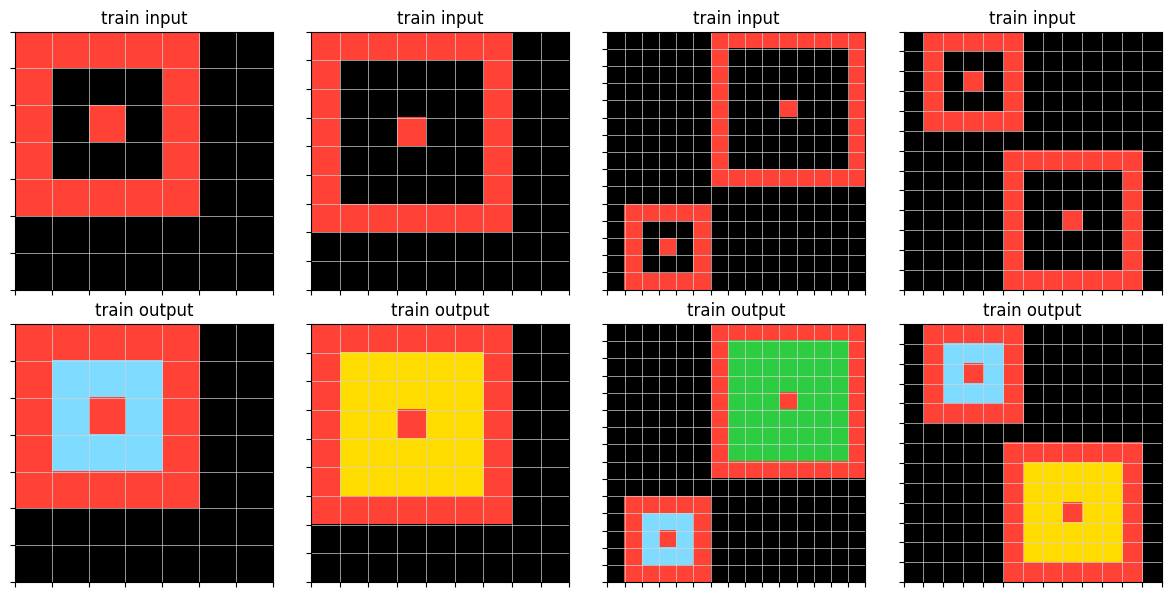

Set #3, 03560426


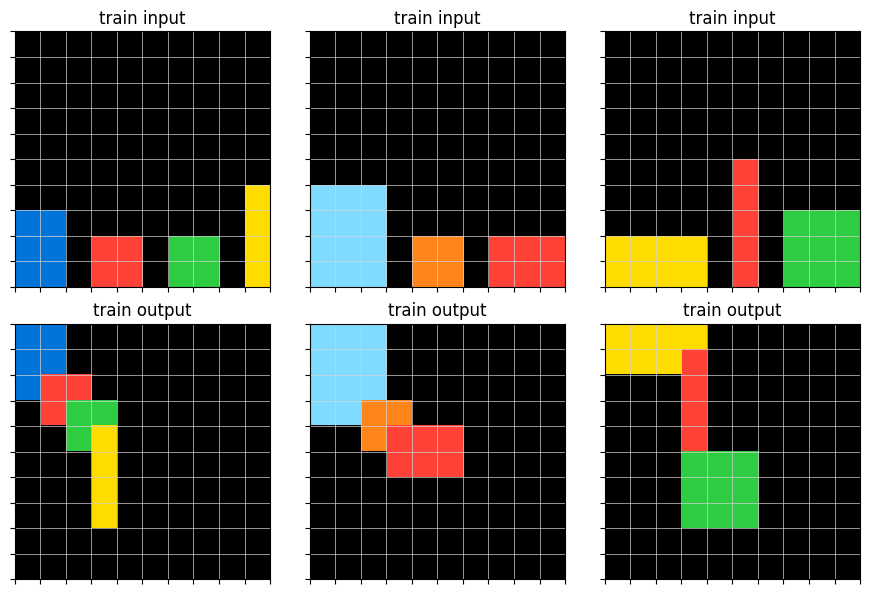

Set #4, 05a7bcf2


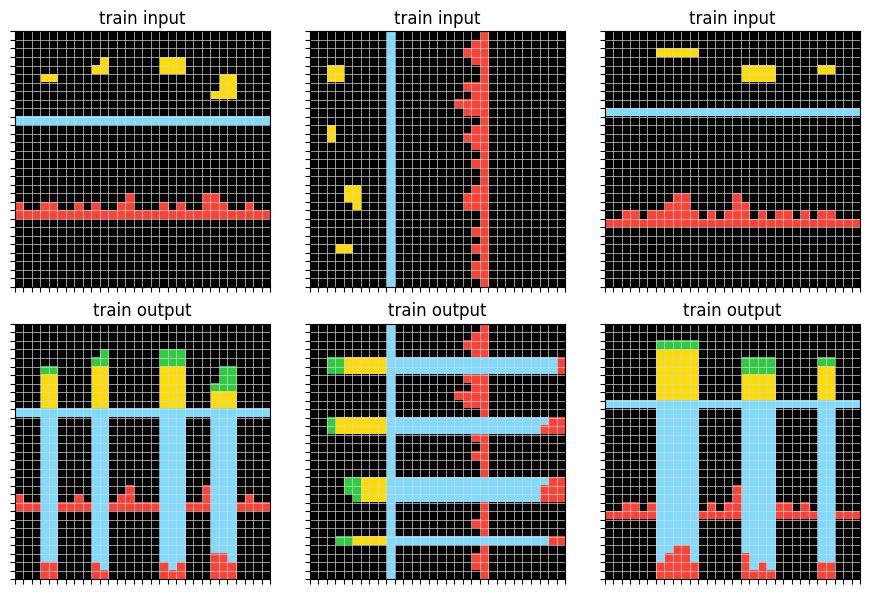

Set #5, 0607ce86


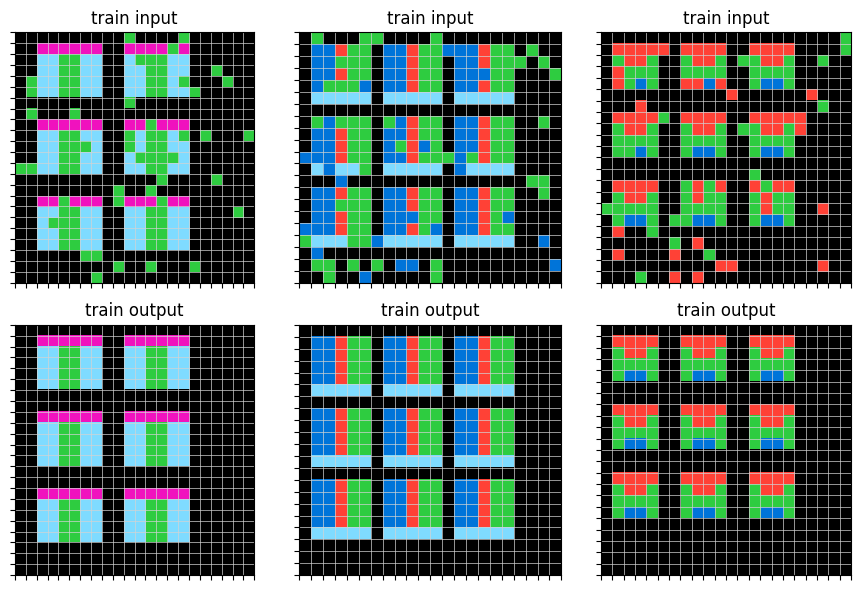

Set #6, 0692e18c


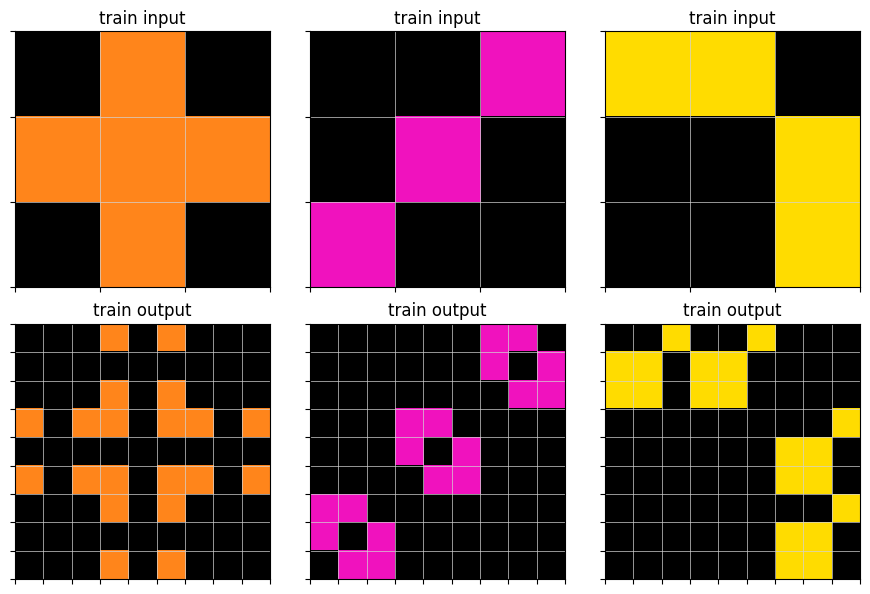

Set #7, 070dd51e


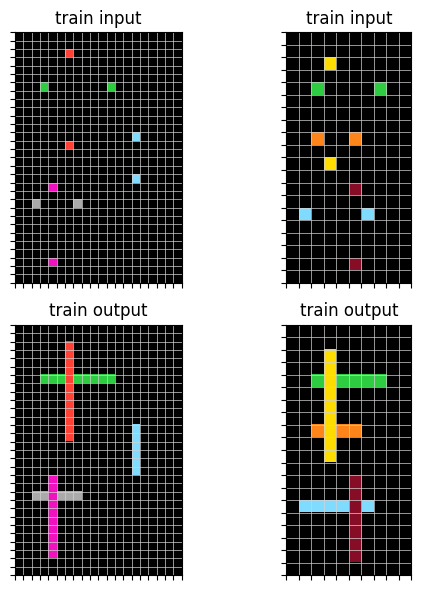

Set #8, 08573cc6


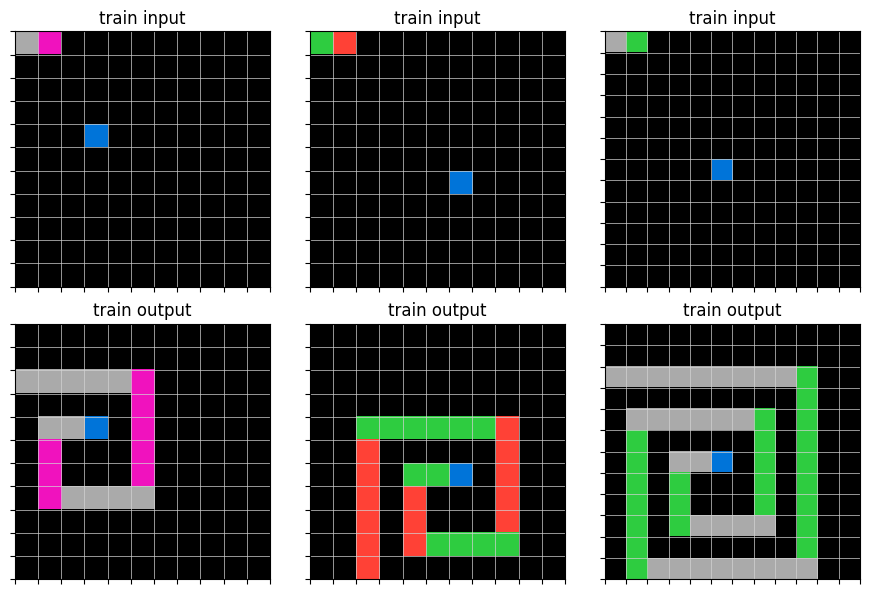

Set #9, 0934a4d8


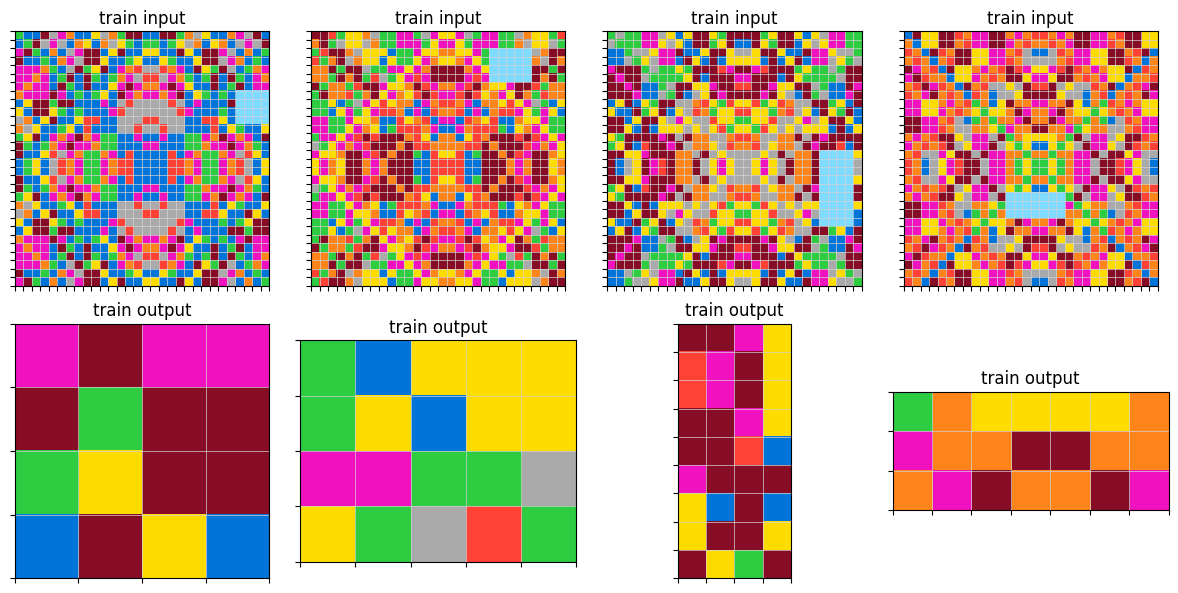

Set #10, 09c534e7


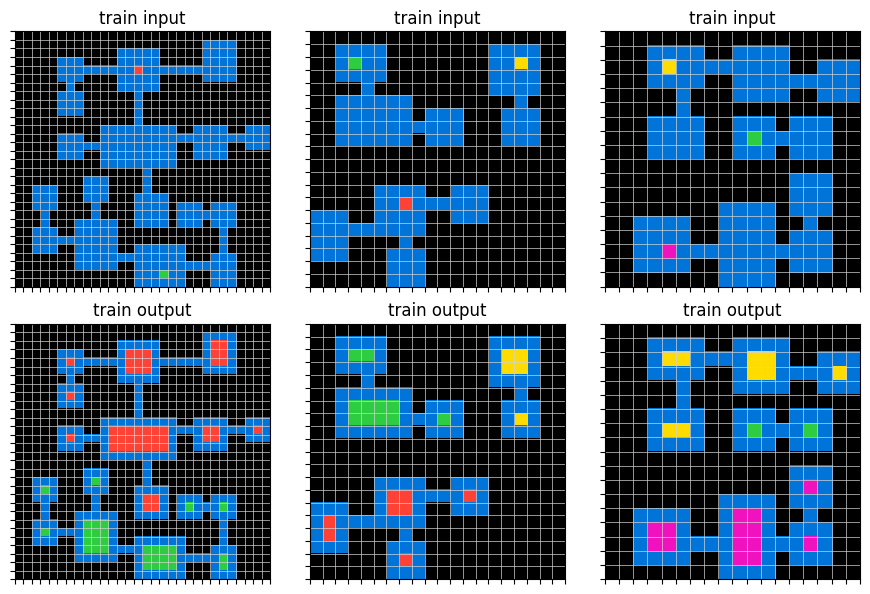

Set #11, 0a1d4ef5


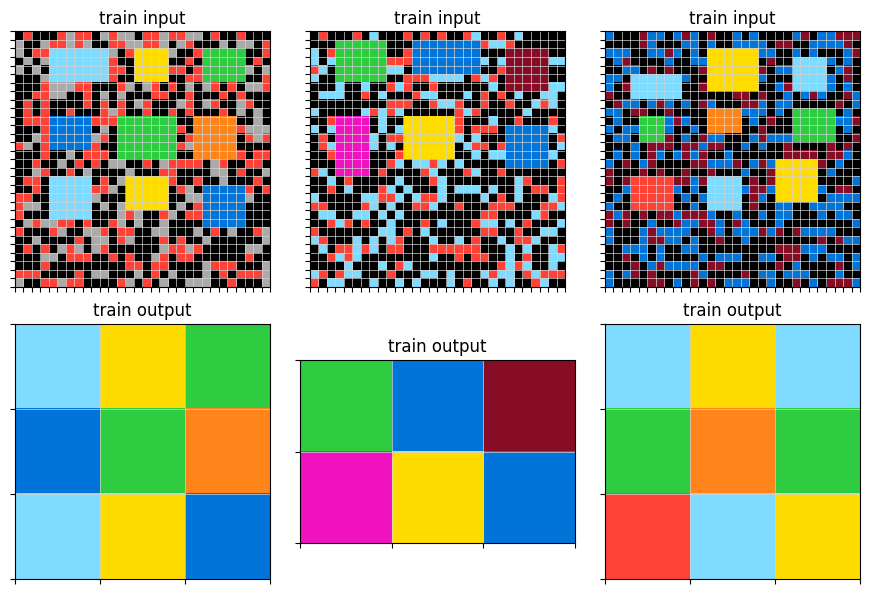

Set #12, 0a2355a6


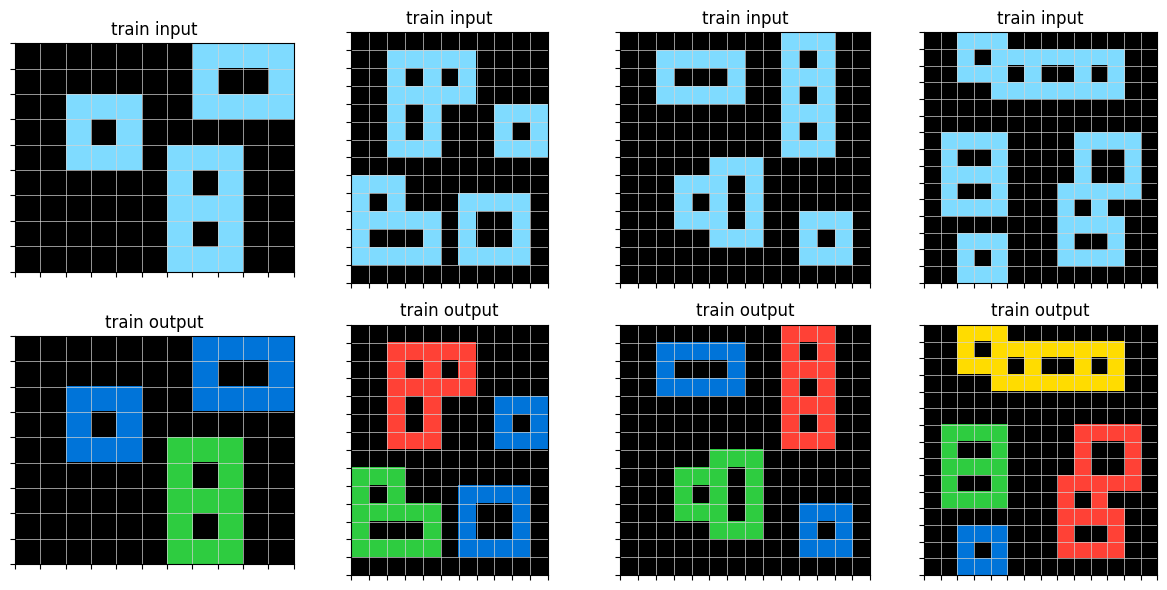

Set #13, 0b17323b


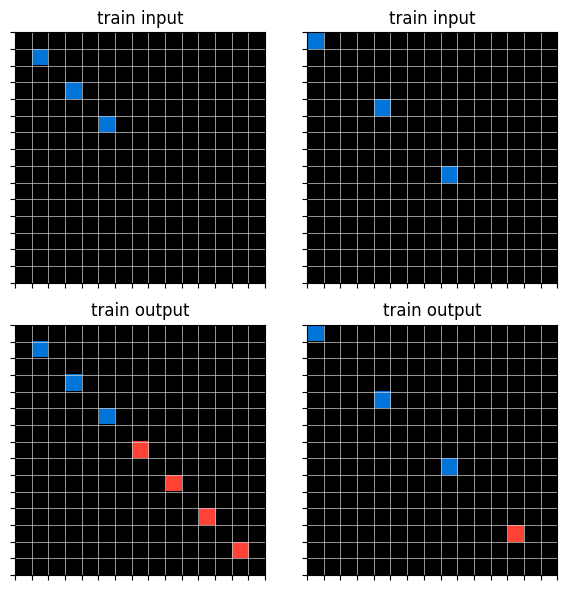

Set #14, 0bb8deee


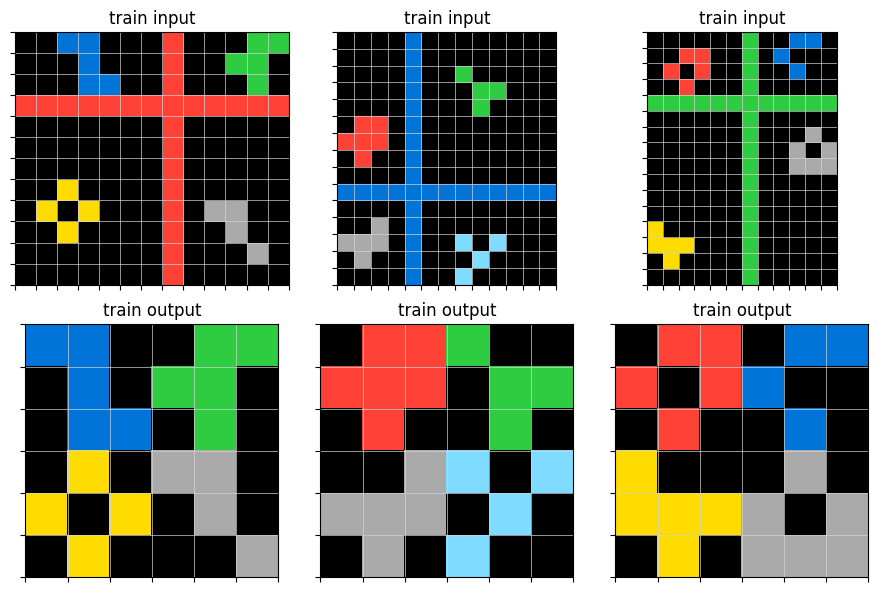

Set #15, 0becf7df


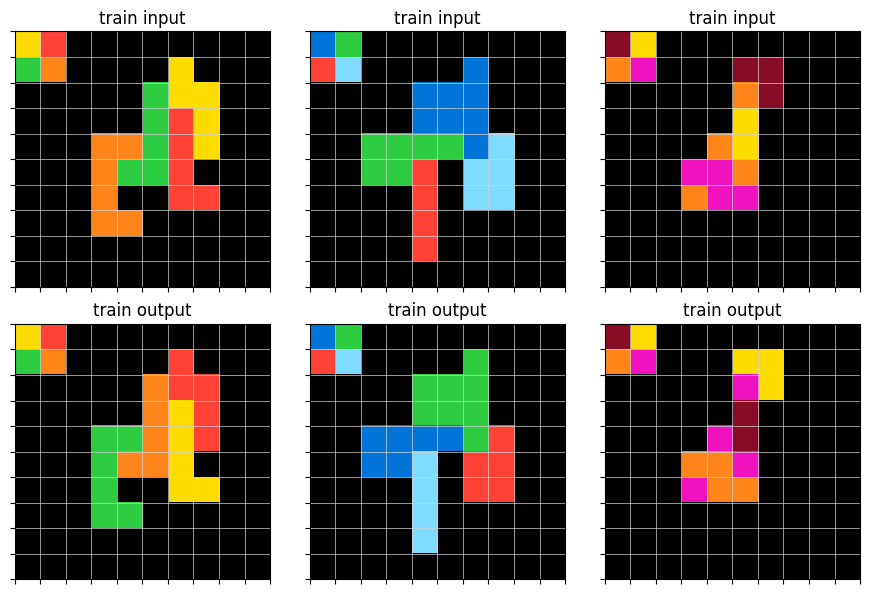

Set #16, 0c786b71


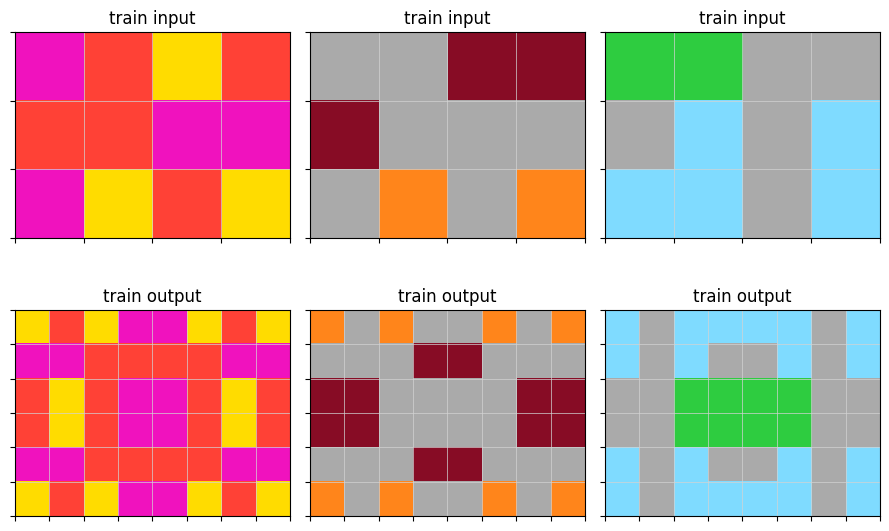

Set #17, 0c9aba6e


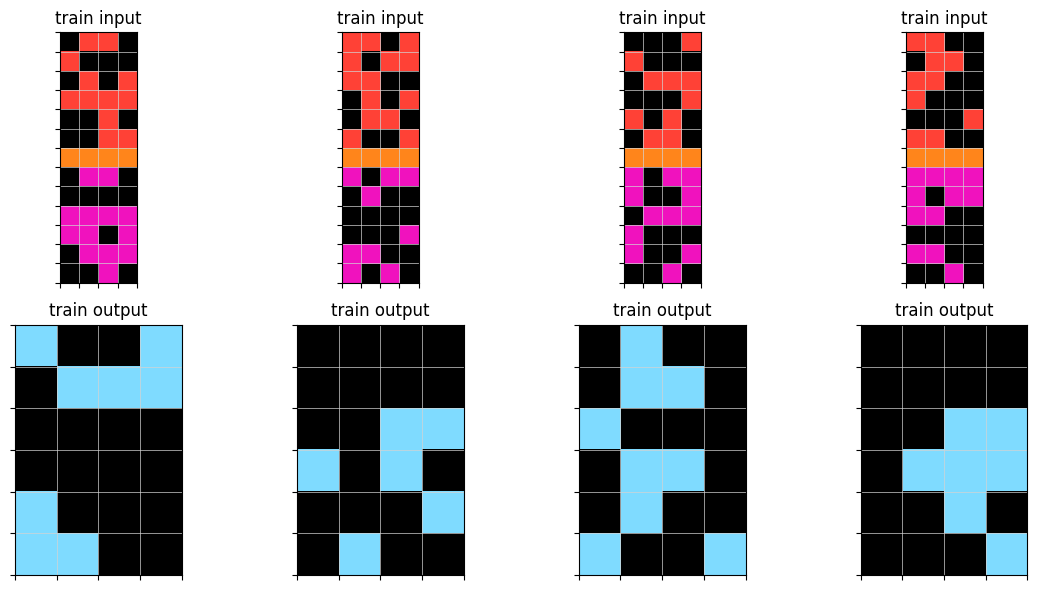

Set #18, 0d87d2a6


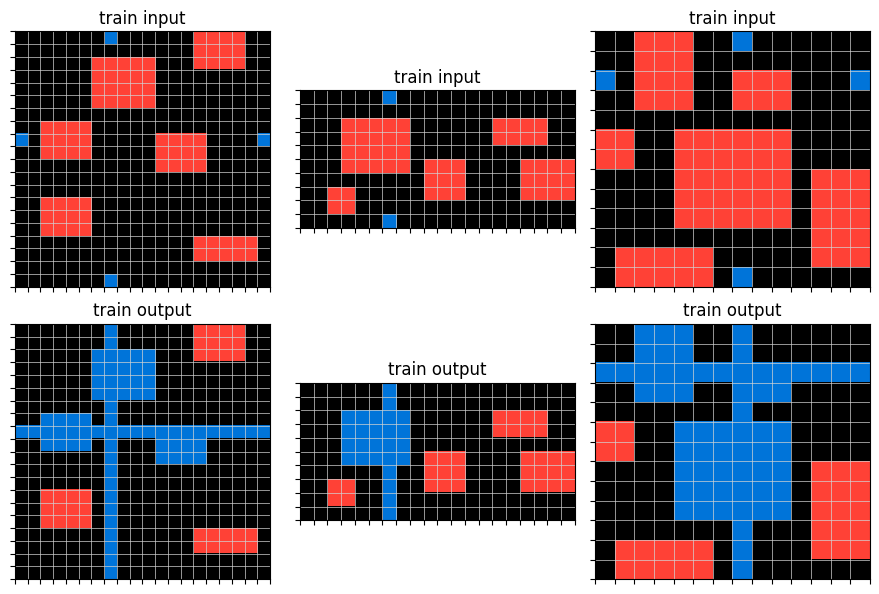

Set #19, 0e671a1a


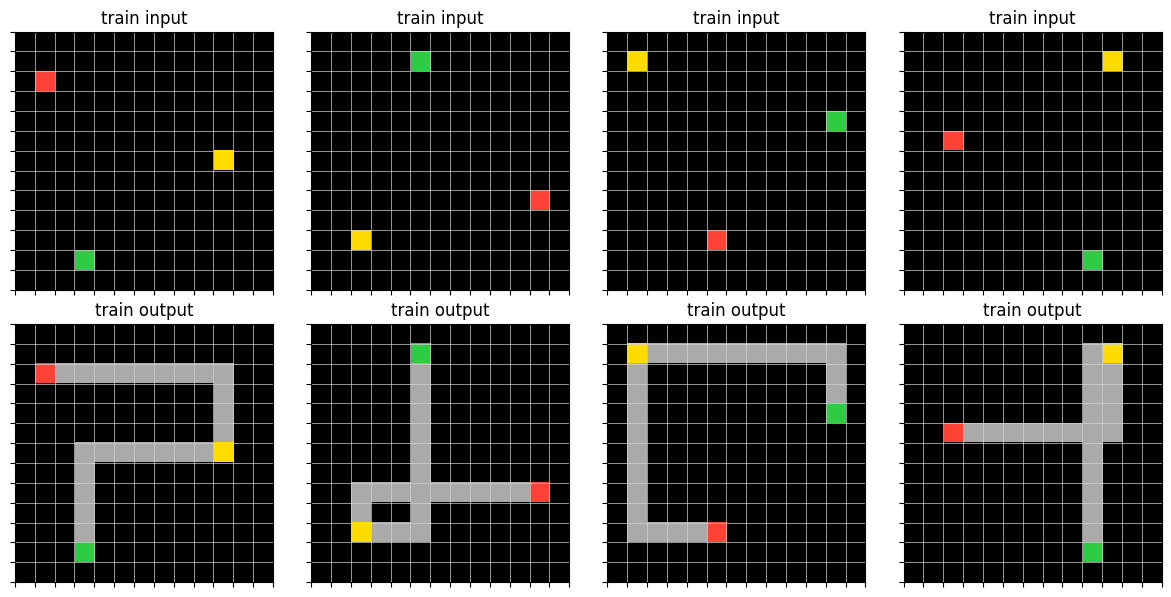

In [15]:
for i in range(20):
    t=list(evaluation_challenges)[i]
    task=evaluation_challenges[t]
    print(f'Set #{i}, {t}')
    plot_task(task)


# <div  style="color:white; border:lightgreen solid;  font-weight:bold; font-size:120%; text-align:center;padding:12.0px; background:black">4. MODELLING</div>


As soon as)

## <div  style="color:#D35142;  font-weight:bold; font-size:100%; text-align:center;padding:12.0px; background:#ffffff"> Please upvote this kernel if you like it. It motivates me to produce more quality content) </div>